In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [95]:
chicago_weather = pd.read_csv("chicago_weather.csv")
chicago_trips = pd.read_csv("cleaned_trips_df.csv")

In [96]:
chicago_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   app_temp         8783 non-null   float64
 1   azimuth          8783 non-null   float64
 2   clouds           8783 non-null   int64  
 3   datetime         8783 non-null   object 
 4   dewpt            8783 non-null   float64
 5   dhi              8783 non-null   int64  
 6   dni              8783 non-null   int64  
 7   elev_angle       8783 non-null   float64
 8   ghi              8783 non-null   int64  
 9   h_angle          0 non-null      float64
 10  pod              8783 non-null   object 
 11  precip           8783 non-null   float64
 12  pres             8783 non-null   int64  
 13  revision_status  8783 non-null   object 
 14  rh               8783 non-null   int64  
 15  slp              8783 non-null   int64  
 16  snow             8783 non-null   float64
 17  solar_rad     

# 1 Match Time Period of Datasets
Before preprocessing the weather data, we need to verify the time coverage to ensure compatibility when merging it with other datasets.

In [97]:
# display time period of our trip data
chicago_trips['Trip End Timestamp'] = pd.to_datetime(chicago_trips['Trip End Timestamp'])
trip_time = chicago_trips.sort_values(by='Trip End Timestamp').reset_index(drop=True)

print("Trip Data Time Period:")
print("\t Earliest Date Time:", trip_time['Trip End Timestamp'].iloc[0])
print("\t Latest Date Time:", trip_time['Trip End Timestamp'].iloc[-1])

# validate the time period of the weather dataset
chicago_weather['timestamp_utc'] = pd.to_datetime(chicago_weather['timestamp_utc'])
df_chicago_temp = chicago_weather.sort_values(by='timestamp_utc').reset_index(drop=True)

print("\nWeather Data Time Period:")
print("\t Earliest Date Time:", df_chicago_temp['timestamp_utc'].iloc[0])
print("\t Latest Date Time:", df_chicago_temp['timestamp_utc'].iloc[-1])



Trip Data Time Period:
	 Earliest Date Time: 2024-01-01 00:00:00
	 Latest Date Time: 2025-05-01 13:30:00

Weather Data Time Period:
	 Earliest Date Time: 2024-01-01 06:00:00
	 Latest Date Time: 2025-01-01 05:00:00


In [98]:
# check if any hourly entries are missing

# Step 1: Parse to timezone-aware UTC
# chicago_weather['timestamp_utc'] = pd.to_datetime(chicago_weather['timestamp_utc'], utc=True)

# Step 2: Floor to the hour
floored_hours = chicago_weather['timestamp_utc'].dt.floor('H')

# Step 3: Generate expected full set of hourly timestamps
expected_hours = pd.date_range(start=floored_hours.min(),
                               end=floored_hours.max(),
                               freq='H',
                               tz='UTC')

# Step 4: Compare using ISO format strings
expected_hour_strs = set(expected_hours.strftime('%Y-%m-%dT%H:%M:%S%z'))
observed_hour_strs = set(floored_hours.dt.strftime('%Y-%m-%dT%H:%M:%S%z'))

# Step 5: Identify missing hour strings
missing_hour_strs = sorted(expected_hour_strs - observed_hour_strs)

# Step 6: Convert back to timezone-aware datetime
missing_hours = pd.to_datetime(missing_hour_strs)

# Step 7: Output
print("Missing hourly timestamps (UTC):")
print(missing_hours)
print(f"\nTotal missing hours: {len(missing_hours)}")


Missing hourly timestamps (UTC):
DatetimeIndex(['2024-01-01 06:00:00+00:00', '2024-01-01 07:00:00+00:00',
               '2024-01-01 08:00:00+00:00', '2024-01-01 09:00:00+00:00',
               '2024-01-01 10:00:00+00:00', '2024-01-01 11:00:00+00:00',
               '2024-01-01 12:00:00+00:00', '2024-01-01 13:00:00+00:00',
               '2024-01-01 14:00:00+00:00', '2024-01-01 15:00:00+00:00',
               ...
               '2024-12-31 20:00:00+00:00', '2024-12-31 21:00:00+00:00',
               '2024-12-31 22:00:00+00:00', '2024-12-31 23:00:00+00:00',
               '2025-01-01 00:00:00+00:00', '2025-01-01 01:00:00+00:00',
               '2025-01-01 02:00:00+00:00', '2025-01-01 03:00:00+00:00',
               '2025-01-01 04:00:00+00:00', '2025-01-01 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8784, freq=None)

Total missing hours: 8784


/var/folders/mx/mgs457fj45n14v_glyg8_qwc0000gn/T/ipykernel_77650/2017399814.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  floored_hours = chicago_weather['timestamp_utc'].dt.floor('H')
/var/folders/mx/mgs457fj45n14v_glyg8_qwc0000gn/T/ipykernel_77650/2017399814.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start=floored_hours.min(),


We identified three different locations of missing entries:
- from 2024-01-01 00:00 to 05:00, filled with weather data of 2024-01-01 06:00 (earliest datapoint we have)
- 2024-11-03 07:00, filled with weather data of 2024-11-03 06:00 (data of one hour earlier)
- from 2025-01-01 06:00 to 14:00, filled with weather data of 2025-01-01 05:00 (latest datapoint we have)

In [99]:
# Ensure datetime is parsed correctly
chicago_weather['timestamp_utc'] = pd.to_datetime(chicago_weather['timestamp_utc'], utc=True)

# remove default indexing
chicago_weather = chicago_weather.reset_index(drop=True)

# Set timestamp as index
chicago_weather = chicago_weather.set_index('timestamp_utc')

# --------------------------------------------
# Fill missing rows from 2024-01-01 00:00 to 05:00
# --------------------------------------------

ref_time_1 = pd.Timestamp("2024-01-01 06:00:00", tz='UTC')
reference_row_1 = chicago_weather.loc[ref_time_1]

new_times_1 = pd.date_range(start="2024-01-01 00:00:00", end="2024-01-01 05:00:00", freq='H', tz='UTC')
new_rows_1 = pd.DataFrame([reference_row_1] * len(new_times_1), index=new_times_1)

# --------------------------------------------
# Fill missing row: 2024-11-03 07:00 using 06:00
# --------------------------------------------

ref_time_2 = pd.Timestamp("2024-11-03 06:00:00", tz='UTC')
target_time_2 = pd.Timestamp("2024-11-03 07:00:00", tz='UTC')

reference_row_2 = chicago_weather.loc[ref_time_2]
reference_row_2.name = target_time_2
new_rows_2 = pd.DataFrame([reference_row_2], index=[target_time_2])

# --------------------------------------------
# Add rows from 2025-01-01 05:00 to 14:00 using last known row of that day
# --------------------------------------------

# Find last available timestamp on 2025-01-01
jan1_rows = chicago_weather.loc["2025-01-01"]
latest_time = jan1_rows.index.max()
reference_row_3 = chicago_weather.loc[latest_time]

# Fix timezone mismatch issue explicitly
start_time = (latest_time + pd.Timedelta(hours=1)).tz_convert('UTC')
end_time = pd.Timestamp("2025-01-01 14:00:00", tz='UTC')

new_times_3 = pd.date_range(start=start_time, end=end_time, freq='H')
new_rows_3 = pd.DataFrame([reference_row_3] * len(new_times_3), index=new_times_3)

# --------------------------------------------
# Combine all new rows with original DataFrame
# --------------------------------------------

df_combined = pd.concat([chicago_weather, new_rows_1, new_rows_2, new_rows_3])
df_combined = df_combined[~df_combined.index.duplicated(keep='first')]
df_combined = df_combined.sort_index().reset_index().rename(columns={'index': 'timestamp_utc'})

# Store final result back
chicago_weather = df_combined

# Show summary
chicago_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   timestamp_utc    8799 non-null   datetime64[ns, UTC]
 1   app_temp         8799 non-null   float64            
 2   azimuth          8799 non-null   float64            
 3   clouds           8799 non-null   int64              
 4   datetime         8799 non-null   object             
 5   dewpt            8799 non-null   float64            
 6   dhi              8799 non-null   int64              
 7   dni              8799 non-null   int64              
 8   elev_angle       8799 non-null   float64            
 9   ghi              8799 non-null   int64              
 10  h_angle          0 non-null      float64            
 11  pod              8799 non-null   object             
 12  precip           8799 non-null   float64            
 13  pres             8

/var/folders/mx/mgs457fj45n14v_glyg8_qwc0000gn/T/ipykernel_77650/2219921245.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_times_1 = pd.date_range(start="2024-01-01 00:00:00", end="2024-01-01 05:00:00", freq='H', tz='UTC')
/var/folders/mx/mgs457fj45n14v_glyg8_qwc0000gn/T/ipykernel_77650/2219921245.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_times_3 = pd.date_range(start=start_time, end=end_time, freq='H')


In [100]:
# Step 1: Parse to timezone-aware UTC
# chicago_weather['timestamp_utc'] = pd.to_datetime(chicago_weather['timestamp_utc'], utc=True)

# Step 2: Floor to the hour
floored_hours = chicago_weather['timestamp_utc'].dt.floor('H')

# Step 3: Generate expected full set of hourly timestamps
expected_hours = pd.date_range(start=floored_hours.min(),
                               end=floored_hours.max(),
                               freq='H',
                               tz='UTC')

# Step 4: Compare using ISO format strings to avoid formatting issues
expected_hour_strs = set(expected_hours.strftime('%Y-%m-%dT%H:%M:%S'))
observed_hour_strs = set(floored_hours.dt.strftime('%Y-%m-%dT%H:%M:%S'))

# Step 5: Identify missing hour strings
missing_hour_strs = sorted(expected_hour_strs - observed_hour_strs)

# Step 6: Convert back to timezone-aware datetime
missing_hours = pd.to_datetime(missing_hour_strs)

# Step 7: Output the result
print("Missing hourly timestamps (UTC):")
for ts in missing_hours:
    print(ts)

print(f"\nTotal missing hours: {len(missing_hours)}")


Missing hourly timestamps (UTC):

Total missing hours: 0


/var/folders/mx/mgs457fj45n14v_glyg8_qwc0000gn/T/ipykernel_77650/1091268402.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  floored_hours = chicago_weather['timestamp_utc'].dt.floor('H')
/var/folders/mx/mgs457fj45n14v_glyg8_qwc0000gn/T/ipykernel_77650/1091268402.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start=floored_hours.min(),


# 2. General Data Cleanup

In [101]:
# check for duplicates
n_duplicates = chicago_weather.duplicated().sum()
print(f"Number of duplicate rows: {n_duplicates}")

Number of duplicate rows: 0


In [102]:
# check for NA values
# Check for NA values and include relative share
for col in chicago_weather.columns:
    null_count = chicago_weather[col].isna().sum()
    total_rows = len(chicago_weather)
    null_share = (null_count / total_rows) * 100
    print(f'Number of null values in column "{col}": {null_count} ({null_share:.2f}%)')


Number of null values in column "timestamp_utc": 0 (0.00%)
Number of null values in column "app_temp": 0 (0.00%)
Number of null values in column "azimuth": 0 (0.00%)
Number of null values in column "clouds": 0 (0.00%)
Number of null values in column "datetime": 0 (0.00%)
Number of null values in column "dewpt": 0 (0.00%)
Number of null values in column "dhi": 0 (0.00%)
Number of null values in column "dni": 0 (0.00%)
Number of null values in column "elev_angle": 0 (0.00%)
Number of null values in column "ghi": 0 (0.00%)
Number of null values in column "h_angle": 8799 (100.00%)
Number of null values in column "pod": 0 (0.00%)
Number of null values in column "precip": 0 (0.00%)
Number of null values in column "pres": 0 (0.00%)
Number of null values in column "revision_status": 0 (0.00%)
Number of null values in column "rh": 0 (0.00%)
Number of null values in column "slp": 0 (0.00%)
Number of null values in column "snow": 0 (0.00%)
Number of null values in column "solar_rad": 0 (0.00%)
Nu

# 3. Column Selection

In [108]:
chicago_weather.columns

Index(['timestamp_utc', 'app_temp', 'azimuth', 'clouds', 'datetime', 'dewpt',
       'dhi', 'dni', 'elev_angle', 'ghi', 'h_angle', 'pod', 'precip', 'pres',
       'revision_status', 'rh', 'slp', 'snow', 'solar_rad', 'temp',
       'timestamp_local', 'ts', 'uv', 'vis', 'weather', 'wind_dir',
       'wind_gust_spd', 'wind_spd', 'date'],
      dtype='object')

As we can see, there are a lot of columns in this dataset. Although the dataset provides detailed weather information for Chicago, not all variables are relevant to our specific use case. Therefore, we decided to keep the following columns and drop all other:
Temperature data:
- timestamp_utc (we can get other time related columns if needed from this column --> dropped redundant information)
- temp (temperature)
- app_temp (apparent temperature)
- rh (relative humidity)
  
Wind data:
- wind_spd
- wind_gust_spd (wind gust speed, basically highest wind speed)

Percipitation & Snow data:
- percip (Percipitation/Rainfall amount)
- snow (Snowfall amount)
  
Sun data:
- ghi (solar radiation, perception of intensity of the sun)
- vis (visibility)

# 4. Outlier Detection

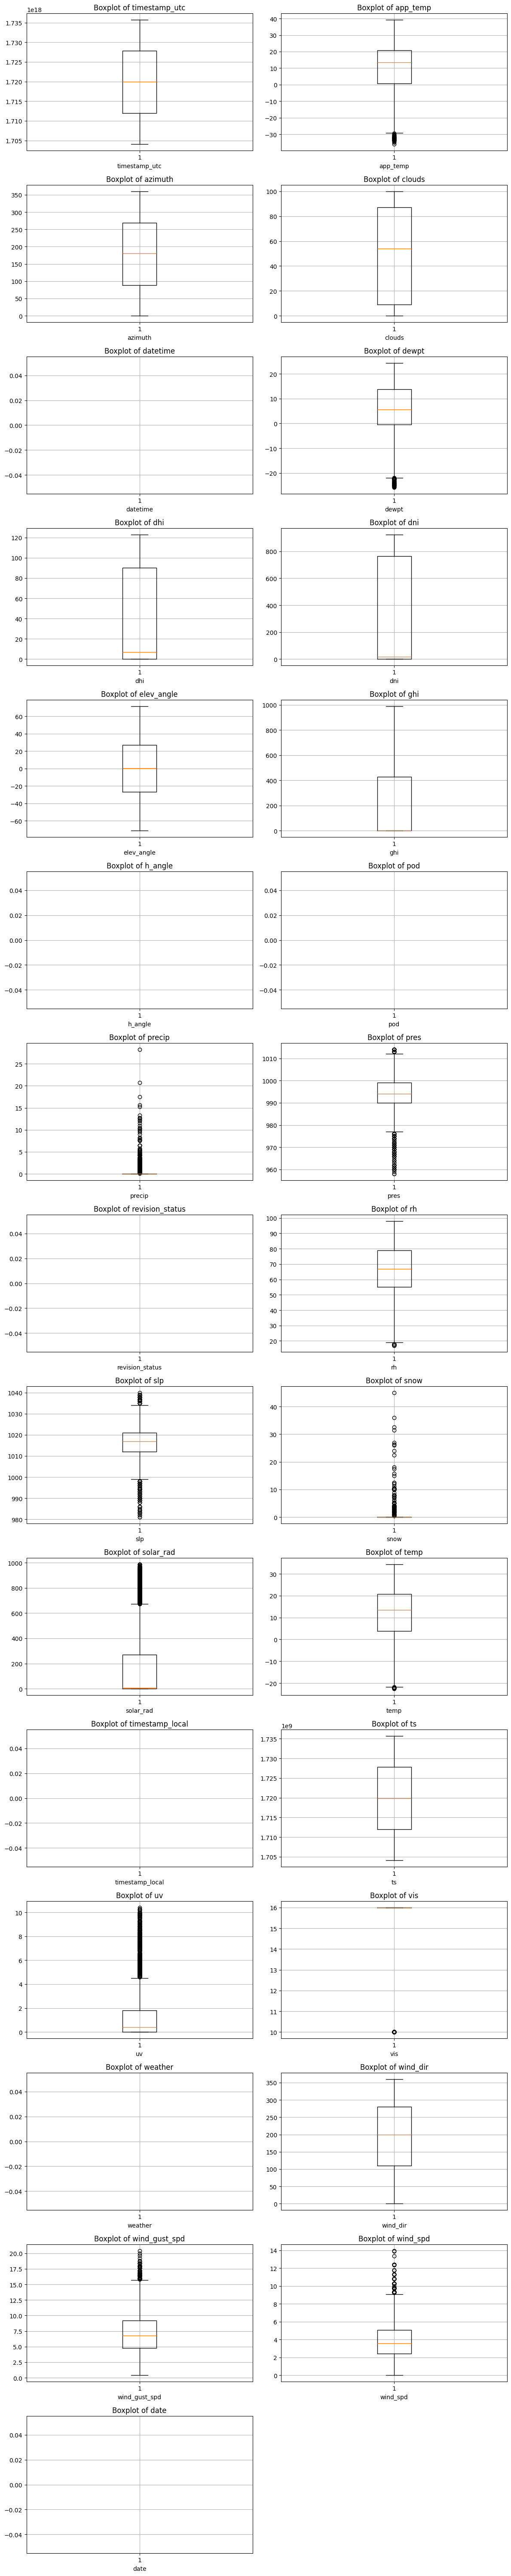

In [ ]:

# 2 plots per row
rows = math.ceil(len(chicago_weather.columns) / 2)

fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))
axes = axes.flatten()

for i, col in enumerate(chicago_weather.columns):
    data = pd.to_numeric(chicago_weather[col], errors='coerce').dropna()
    axes[i].boxplot(data, vert=True)
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].grid(True)

# Remove any unused axes
for j in range(len(chicago_weather.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [105]:
chicago_weather.columns

Index(['timestamp_utc', 'app_temp', 'azimuth', 'clouds', 'datetime', 'dewpt',
       'dhi', 'dni', 'elev_angle', 'ghi', 'h_angle', 'pod', 'precip', 'pres',
       'revision_status', 'rh', 'slp', 'snow', 'solar_rad', 'temp',
       'timestamp_local', 'ts', 'uv', 'vis', 'weather', 'wind_dir',
       'wind_gust_spd', 'wind_spd', 'date'],
      dtype='object')

In [106]:
chicago_weather.head()

,timestamp_utc,app_temp,azimuth,clouds,datetime,dewpt,dhi,dni,elev_angle,ghi,...,temp,timestamp_local,ts,uv,vis,weather,wind_dir,wind_gust_spd,wind_spd,date
0,2024-01-01 00:00:00+00:00,-5.7,4.5,87,2024-01-01:06,-1.5,0,0,-71.1,0,...,0.7,2024-01-01 00:00:00,1704088800,0.0,16,"{'description': 'Overcast clouds', 'code': 804...",320,12.4,8.8,2024-01-01
1,2024-01-01 01:00:00+00:00,-5.7,4.5,87,2024-01-01:06,-1.5,0,0,-71.1,0,...,0.7,2024-01-01 00:00:00,1704088800,0.0,16,"{'description': 'Overcast clouds', 'code': 804...",320,12.4,8.8,2024-01-01
2,2024-01-01 02:00:00+00:00,-5.7,4.5,87,2024-01-01:06,-1.5,0,0,-71.1,0,...,0.7,2024-01-01 00:00:00,1704088800,0.0,16,"{'description': 'Overcast clouds', 'code': 804...",320,12.4,8.8,2024-01-01
3,2024-01-01 03:00:00+00:00,-5.7,4.5,87,2024-01-01:06,-1.5,0,0,-71.1,0,...,0.7,2024-01-01 00:00:00,1704088800,0.0,16,"{'description': 'Overcast clouds', 'code': 804...",320,12.4,8.8,2024-01-01
4,2024-01-01 04:00:00+00:00,-5.7,4.5,87,2024-01-01:06,-1.5,0,0,-71.1,0,...,0.7,2024-01-01 00:00:00,1704088800,0.0,16,"{'description': 'Overcast clouds', 'code': 804...",320,12.4,8.8,2024-01-01
